# HSCT survival gradient boosting decision tree model

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

retrain_models=True

training_features_df_file='./data/processed/02.1-scaled_encoded_training_features_df.parquet'
training_labels_df_file='./data/processed/02.1-scaled_encoded_training_labels_df.parquet'
testing_features_df_file='./data/processed/02.1-scaled_encoded_testing_features_df.parquet'

baseline_model_file='./models/05.1-gradient_boosting_baseline.pkl'
tuned_model_file='./models/05.2-gradient_boosting_tuned.pkl'

## 1. Load data

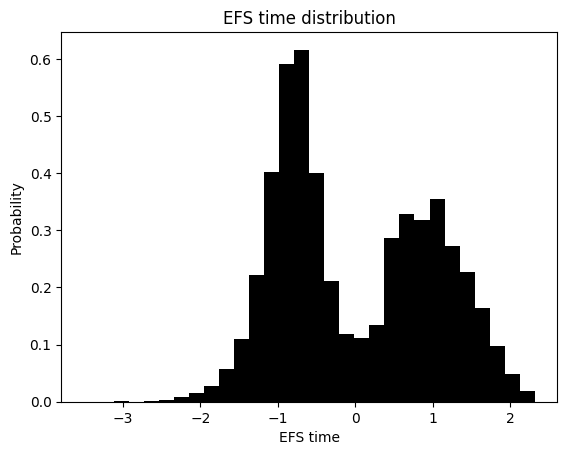

Training features: (28800, 178)


In [2]:
training_features=pd.read_parquet(training_features_df_file)
training_labels=pd.read_parquet(training_labels_df_file)

# Remove id column from training features
training_features.drop('ID', axis=1, inplace=True)

plt.title('EFS time distribution')
plt.hist(training_labels['efs_time'], density=True, bins=30, color='black')
plt.xlabel('EFS time')
plt.ylabel('Probability')
plt.show()

print(f'Training features: {training_features.shape}')

## 2. Baseline model

In [3]:
def cross_val(model, features: pd.DataFrame, labels: pd.Series) -> list[float]:
    '''Reusable helper function to run cross-validation on a model. Takes model,
    Pandas data frame of features and Pandas data series of labels. Returns 
    list of cross-validation fold accuracy scores as percents.'''

    # Define the cross-validation strategy
    cross_validation=KFold(n_splits=7, shuffle=True, random_state=315)

    # Run the cross-validation, collecting the scores
    scores=cross_val_score(
        model,
        features,
        labels,
        cv=cross_validation,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error'
    )

    # Print mean and standard deviation of the scores
    print(f'Cross validation RMSE {-scores.mean():.2f} +/- {scores.std():.2f}')

    # Return the scores
    return scores

# Instantiate default elastic net model
baseline_model=GradientBoostingRegressor(random_state=315)

# Run cross-validation to estimate out-of-sample performance
baseline_scores=cross_val(baseline_model, training_features, training_labels['efs_time'])

Cross validation RMSE 0.91 +/- 0.01


## 3. Fit and evaluate baseline model

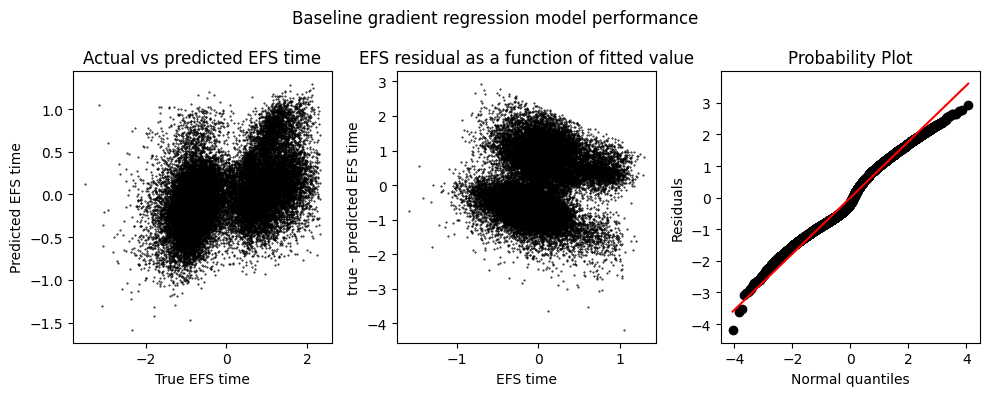

In [4]:
# Train or load model as desired
if retrain_models == True:
    baseline_model.fit(training_features, training_labels['efs_time'])

    with open(baseline_model_file, 'wb') as output_file:
        pickle.dump(baseline_model, output_file)

elif retrain_models == False:
    with open(baseline_model_file, 'rb') as input_file:
        baseline_model=pickle.load(input_file)

# Make predictions for the whole test set
predicted_efs_time=baseline_model.predict(training_features)

# Plot the results
fig, axs=plt.subplots(1,3, figsize=(10,4))
axs=axs.flatten()

fig.suptitle('Baseline gradient regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(training_labels['efs_time'], predicted_efs_time, color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS residual as a function of fitted value')
axs[1].scatter(predicted_efs_time, training_labels['efs_time'] - predicted_efs_time, color='black', s=0.2)
axs[1].set_xlabel('EFS time')
axs[1].set_ylabel('true - predicted EFS time')

axs[2].set_title('Normal quantile plot')
stats.probplot(training_labels['efs_time'] - predicted_efs_time, plot=axs[2])
axs[2].get_lines()[0].set_markeredgecolor('black')
axs[2].get_lines()[0].set_markerfacecolor('black')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

## 4. Hyperparameter tuning

In [5]:
# Train or load model as desired
if retrain_models == True:
    
    # Instantiate the model
    model=GradientBoostingRegressor(random_state=315)

    # Define the cross-validation strategy
    cross_validation=KFold(n_splits=7, shuffle=True, random_state=315)

    # Define the hyperparameter search space
    distributions={
        'learning_rate': stats.uniform(loc=0.00001, scale=0.00999),
        'n_estimators': list(range(10, 500)),
        'max_depth': list(range(5, 10)),
        'min_samples_split': list(range(2, 100)),
        'min_samples_leaf': list(range(2, 100)),
        'subsample': stats.uniform(loc=0.5, scale=0.5)
    }

    # Set-up the search
    search=RandomizedSearchCV(
        model,
        distributions,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        cv=cross_validation,
        n_iter=50,
        random_state=315,
        return_train_score=True
    )

    results=search.fit(training_features, training_labels['efs_time'])
    print(f'Best hyperparameters: {results.best_params_}')

Best hyperparameters: {'learning_rate': np.float64(0.008103082473159667), 'max_depth': 9, 'min_samples_leaf': 80, 'min_samples_split': 91, 'n_estimators': 443, 'subsample': np.float64(0.5869333821364152)}


## 5. Fit and evaluate tuned model

Cross validation RMSE 0.91 +/- 0.01


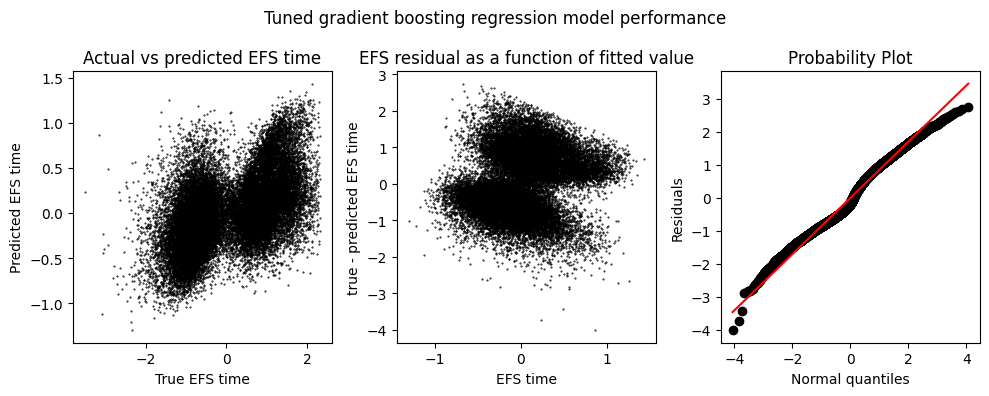

In [6]:
# Train or load model as desired
if retrain_models == True:
    
    # Instantiate the model with the tuned hyperparameters
    tuned_model=GradientBoostingRegressor(**results.best_params_, random_state=315)
    tuned_model.fit(training_features, training_labels['efs_time'])

    with open(tuned_model_file, 'wb') as output_file:
        pickle.dump(tuned_model, output_file)

elif retrain_models == False:
    with open(tuned_model_file, 'rb') as input_file:
        tuned_model=pickle.load(input_file)

# Run cross-validation to estimate out-of-sample performance
tuned_scores=cross_val(model, training_features, training_labels['efs_time'])

# Make predictions on the training set
predicted_efs_time=tuned_model.predict(training_features)

# Plot the results
fig, axs=plt.subplots(1,3, figsize=(10,4))
axs=axs.flatten()

fig.suptitle('Tuned gradient boosting regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(training_labels['efs_time'], predicted_efs_time, color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS residual as a function of fitted value')
axs[1].scatter(predicted_efs_time, training_labels['efs_time'] - predicted_efs_time, color='black', s=0.2)
axs[1].set_xlabel('EFS time')
axs[1].set_ylabel('true - predicted EFS time')

axs[2].set_title('Normal quantile plot')
stats.probplot(training_labels['efs_time'] - predicted_efs_time, plot=axs[2])
axs[2].get_lines()[0].set_markeredgecolor('black')
axs[2].get_lines()[0].set_markerfacecolor('black')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

## 6. Make test set predictions

In [7]:
testing_features_df=pd.read_parquet(testing_features_df_file)
ids=testing_features_df['ID']
testing_features_df.drop('ID', axis=1, inplace=True)
predicted_efs_time=tuned_model.predict(testing_features_df)
scaler=MinMaxScaler()
scaler.fit(predicted_efs_time.reshape(-1, 1))
predicted_efs_time=scaler.transform(predicted_efs_time.reshape(-1, 1))

predictions_df=pd.DataFrame.from_dict({'ID': ids, 'prediction': predicted_efs_time.flatten()})
predictions_df.describe()

,ID,prediction
count,3.0,3.000000
mean,28801.0,0.462892
std,1.0,0.504114
min,28800.0,0.000000
25%,28800.5,0.194338
50%,28801.0,0.388676
75%,28801.5,0.694338
max,28802.0,1.000000
